In [1]:
def shift_elements(arr, num, fill_value):
    """"shifting function, with a fill value;
        if just want to "roll it" use np.roll"""
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.nanargmin(np.abs(array - value))
    return idx #array[idx]

In [3]:
def vertinterpolate(var,lev, zlev_int,method=None):
    """Interpolate data unified 0.5 km vertical levels. (except in the first km)
    
    The default uses numpy interp, but scipy interp1d can also be
    chosen via method="scipy". Scipy interp1d however is much slower."""

    #import xarray as xr
    import numpy as np
    from scipy import interpolate

    var_int = np.zeros((len(zlev_int)))

    # loop over requested variables
    if method == "scipy":
        f_int = interpolate.interp1d(lev[:], var[:], bounds_error=False, kind="linear", fill_value="nan")
        var_int[:] = f_int(zlev_int)
    else:
        var_int[:] = np.interp(zlev_int[:], lev[:], var[:])

    return var_int

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib.patches import Rectangle
import copy
import xarray as xr
import glob 

#make path to the moodule
#import sys
#sys.path.append('/jetfs/home/bgasparini/scripts/plotting/modules_python/')
#import util_rcemip

In [5]:
path = '../../data/RCEMIP_processed/'

ssts = ['295','305']
col = ['k','orange','crimson']
plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
variables = ['hr_acre','temperature'] 

ds = xr.open_dataset(path+'RCElarge_z24_merged_1D_averages_multiplevars2.nc')
models = ds['names_of_models'].values

In [6]:
# target vertical levels
zlev_int = np.arange(0, 24.001, 0.05) #50 m grid spacing
ssts = ['295','300','305']
models = ['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
          'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1']

#regrid the variables you selected above
dataint={}
for v,variable in enumerate(variables):
    dataint[variable]={}
    for m,model in enumerate(models):
        dataint[variable][model]={}

        for s,sst in enumerate(ssts):
            dataint[variable][model][sst]={}
            plotvar = (ds[variable][m,s]).values

            var_interp = vertinterpolate(plotvar,ds['alt'].values,zlev_int,method='scipy')
            dataint[variable][model][sst]=var_interp

In [7]:
#vertshift large shift only as per FINAL_geometry.ipynb
optimal_vertshift = [ 3450.,  3400.,  3200.,  3550.,  3050.,  2850.,  2000.,  3700.,
        2600., -1150.,  3100.,  4550.,  2850.,  2550.,  3000.,  3350.,
        3050.,  3150.,  2550.]

temp_cold= np.zeros(len(models))
temp_warm = np.zeros(len(models))
temp_warm_optimal_vertshift= np.zeros(len(models))
temp_anom_warm_optimal_vertshift= np.zeros(len(models))
temp_anom_warm= np.zeros(len(models))

temp_anom11= np.zeros(len(models))

for m,model in enumerate(models):
    temp_cold[m] = dataint['temperature'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])]
    temp_warm[m] = dataint['temperature'][model]['305'][np.nanargmax(dataint['hr_acre'][model]['305'])]

    #here done based on physical assumptions of isothermal shift
    optimal_ind = int(optimal_vertshift[m]/50 )
    print(optimal_ind,model)

    temp_warm_optimal_vertshift[m] = dataint['temperature'][model]['305'][np.nanargmax(dataint['hr_acre'][model]['295'])+optimal_ind]
    temp_anom_warm_optimal_vertshift[m] = temp_warm_optimal_vertshift[m] - temp_cold[m]
    temp_anom_warm[m] = temp_warm[m]-temp_cold[m]

69 MESONH
68 NICAM
64 SAM_CRM
71 SAM_GCRM
61 SCALE
57 dam
40 MPAS
74 UCLA-CRM
52 CAM5_GCM
-23 CAM6_GCM
62 CNRM-CM6-1
91 GEOS_GCM
57 ICON_LEM_CRM
51 ICON_NWP_CRM
60 SP-CAM
67 SPX-CAM
61 UKMO-GA7.1
63 CM1


/tmp/ipykernel_2947094/3993082322.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=models, rotation=40, ha='right',size=16)


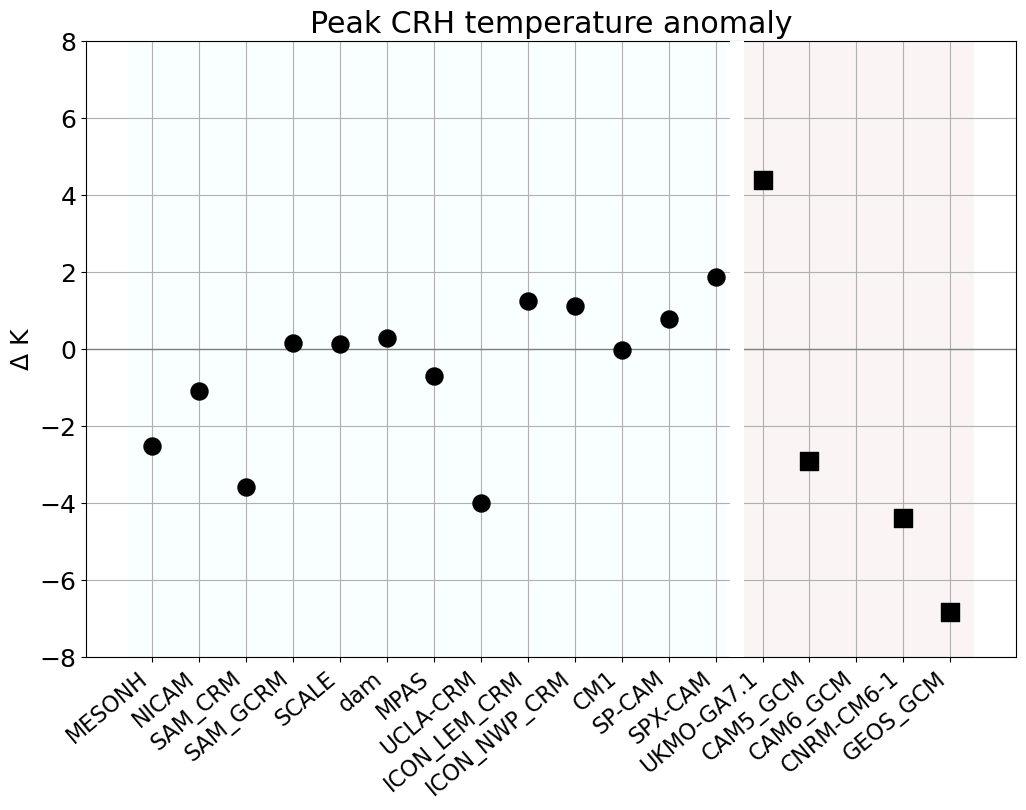

In [8]:
#GCMS numbers = 8,9,10,11,16, super param 14,15

mmm = np.array(['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
            'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1'])
idx = [0,1,2,3,4,5,6,7,12,13,17,14,15,16,8,9,10,11]
models = mmm[idx] #turn the order

temp_anom_warm_optimal_vertshift2 = np.copy(temp_anom_warm_optimal_vertshift)
temp_anom_warm_optimal_vertshift2 = temp_anom_warm_optimal_vertshift2[idx]

fig = plt.figure()
fig.set_size_inches(12,8,forward=True)
gs = gridspec.GridSpec(1,1,height_ratios=[1],width_ratios=1*[1])

ax = fig.add_subplot(gs[0,0])

x_pos = np.arange(len(models)+4)
for m in range(0,len(models)):
        plt.scatter(x_pos[m],temp_anom_warm_optimal_vertshift2[m],color='k',s=150,zorder=111)

        if m in (13,14,15,16,17):
            plt.scatter(x_pos[m],temp_anom_warm_optimal_vertshift2[m],marker='s',color='k',s=150,zorder=111)

ax.set_xticklabels(labels=models, rotation=40, ha='right',size=16)
ax.set_xticks(x_pos[:18])
plt.ylim(-8,8)

plt.axhline(y=0,color='gray',linewidth=1)

plt.axvspan(12.3, 12.6, facecolor='white',alpha=1,zorder=111)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((12.5, -95), 5, 220,
                      alpha=0.05, facecolor='brown'))
currentAxis.add_patch(Rectangle((-0.5, -95), 12.75, 220,
                      alpha=0.35, facecolor='azure'))

plt.ylabel('$\Delta$ K')
plt.title('Peak CRH temperature anomaly')
plt.grid(True)
#plt.savefig('/path-to-file/Fig_S1_peak_CRH_temp_anomalies.pdf',bbox_inches='tight')